## 3 - Develop Model

Cycle through creating features, tuning models, and training/validating models.

### Import libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import warnings
warnings.filterwarnings('ignore')

from EvaluateModels import EvaluateModels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
# nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, learning_curve
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

In [14]:
with open("cleaned_data.json") as f:
    df_data = pd.read_json(f)
df_data.drop(columns=['company', 'location', 'salary', 'position', 'position2', 'level'], inplace=True)
# df_data.describe(include='all')

In [15]:
x_train, x_test, y_train, y_test = train_test_split(df_data['jobdescription'], df_data['label'],
                               test_size=0.30,
                               random_state=123,
                               stratify= df_data['label'])


print("x_train shape is", x_train.shape, " and x_test shape is ", x_test.shape)
print("y_train shape is", y_train.shape, " and y_test shape is ", y_test.shape)

x_train shape is (327,)  and x_test shape is  (141,)
y_train shape is (327,)  and y_test shape is  (141,)


### Text Pre-processing

In [16]:
# Initialize Vectorizer
cvec = CountVectorizer(analyzer = 'word', stop_words = ENGLISH_STOP_WORDS, lowercase= True, min_df=4)

# Fit text data
cvec.fit(x_train.values)

x_train_tfidf = cvec.transform(x_train.values)
x_test_tfidf = cvec.transform(x_test.values)

print("x_train_tfidf shape:", x_train_tfidf.shape)
print("x_test_tfidf shape:", x_test_tfidf.shape)

x_train_tfidf shape: (327, 3259)
x_test_tfidf shape: (141, 3259)


### Test Baseline Models

To begin modeling, we'll create a baseline of performance by selecting a suite of different algorithms capable of working on classification problems.

In [17]:
# Instantiate classifiers to compare
models = [
    ('LR', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier()),
    ('SVC', SVC()),
    ('NB', MultinomialNB())
]

model_names = []
cv_std = {}
model_scores = {}

In [18]:
def train_baseline_model(model, x_train_tfidf, y_train, y_test, model_scores, name, num_folds=5, seed=34):
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_score = cross_validate(model, x_train_tfidf, y_train, cv=kfold)
    model_names.append(name)
    model_scores[model] = cv_score

def print_summary(model, model_scores, cv_std):
    print('\nModel: ', model)
    print(f'  - Average CV score: {np.mean(model_scores[model])}')
    print(f'  - Standard deviation during CV: {np.std(model_scores[model])}')

In [19]:
print("Begin cross validating models:")
for name, model in models:
    train_baseline_model(model, x_train_tfidf, y_train, y_test, model_scores, name)
    print_summary(model, model_scores, cv_std)

Begin cross validating models:

Model:  LogisticRegression()
  - Average CV score: 0.9326340326340328
  - Standard deviation during CV: 0.03154286308716173

Model:  KNeighborsClassifier()
  - Average CV score: 0.785920745920746
  - Standard deviation during CV: 0.04000793222842295

Model:  DecisionTreeClassifier()
  - Average CV score: 0.9052214452214453
  - Standard deviation during CV: 0.022356050208206784

Model:  SVC()
  - Average CV score: 0.9235897435897436
  - Standard deviation during CV: 0.03349915557579514

Model:  MultinomialNB()
  - Average CV score: 0.9234498834498834
  - Standard deviation during CV: 0.0309585192648691


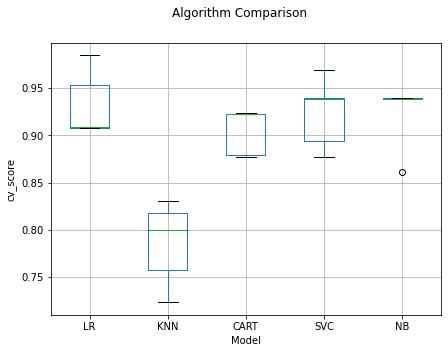

In [20]:
base_df = pd.DataFrame(model_scores)
base_df.columns = model_names

fig, ax = plt.subplots(figsize = (7,5))
fig.suptitle("Algorithm Comparison")
base_df.boxplot()
plt.ylabel("cv_score")
plt.xlabel("Model")
plt.show()

LR has the highest average score and was closely followed by SVC and NB models. The kNN model clearly performed the worst. We will try a few different preprocessing techniques to try and improve the scores of these models.

### Additional Text Pre-processing

There are additional pre-processing steps that can be performed to further improve baseline model performance. We will start with a different vectorizer to extract text features.

In [27]:
tvec = TfidfVectorizer(analyzer = 'word', stop_words = ENGLISH_STOP_WORDS, lowercase= True, min_df=4)
vecs = [cvec, tvec]
model = LogisticRegression()
parameters = {'vectorizer': vecs}

In [28]:
pipe = Pipeline([('vectorizer', cvec), ('model', LogisticRegression())])
grid = GridSearchCV(pipe, param_grid = parameters, cv=5, scoring='accuracy', return_train_score=True)
grid.fit(x_train.values, y_train.values)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(min_df=4,
                                                        stop_words=frozenset({'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'all',
                                                                            

In [29]:
print(f'Training set score: {str(grid.score(x_train.values, y_train.values))}')
print(f'Test set score: {str(grid.score(x_test.values, y_test.values))}')

Training set score: 1.0
Test set score: 0.9574468085106383


In [30]:
# Print the best score
best_score = grid.best_score_
print(f'The best mean cv score is {best_score}')

# Access the best set of parameters
best_params = grid.best_params_
print(best_params)

# Stores the optimum model in best_pipe
best_pipe = grid.best_estimator_
print(best_pipe)

The best mean cv score is 0.9387878787878787
{'vectorizer': CountVectorizer(min_df=4,
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}))}
Pipeline(steps=[('vectorizer',
                 CountVectorizer(min_df=4,
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
             

In [32]:
result_df = pd.DataFrame(grid.cv_results_)

# get list of parameters for plot labels
col_label = [col for col in result_df.columns if 'param_' in col]
col_label = str(col_label[0])
plot_labels = result_df[col_label].values.tolist()
plot_label = [str(i).split('(')[0] for i in plot_labels]
print(plot_label)

# take just cv scores and plot them
score_cols = [col for col in result_df.columns if 'split' in col]
test_score_df = result_df[score_cols].T
# test_score_df

['CountVectorizer', 'TfidfVectorizer']


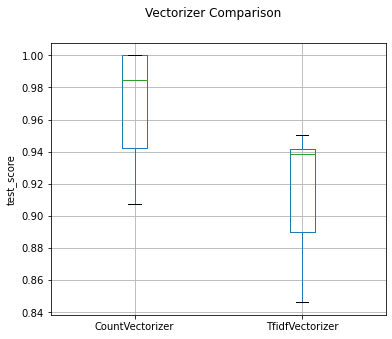

In [33]:
fig, ax = plt.subplots(figsize = (6,5))
fig.suptitle("Vectorizer Comparison")
test_score_df.boxplot()
plt.ylabel("test_score")
ax.set_xticklabels(plot_label)
plt.show()

### Pipeline to Check Baseline Models with TfidfVectorizer

In [34]:
models = [LogisticRegression(), KNeighborsClassifier(), DecisionTreeClassifier(), SVC(), MultinomialNB()]
parameters = {'model': models}

pipe = Pipeline([('vectorizer', tvec), ('model', LogisticRegression())])
grid = GridSearchCV(pipe, param_grid = parameters, cv=5, scoring='accuracy')
grid.fit(x_train.values, y_train.values)

print('Scores:')
print(f' -- Training set score: {str(grid.score(x_train.values, y_train.values))}')
print(f' -- Test set score: {str(grid.score(x_test.values, y_test.values))}')

Scores:
 -- Training set score: 0.9969418960244648
 -- Test set score: 0.9432624113475178


In [36]:
best_score = grid.best_score_
print(f'The best mean cv score is {best_score}')

# Access the best set of parameters
best_params = grid.best_params_
print(f'The best model parameters are {best_params}')

# Stores the optimum model in best_pipe
best_pipe = grid.best_estimator_
print(best_pipe)

The best mean cv score is 0.9265268065268065
The best model parameters are {'model': SVC()}
Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(min_df=4,
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any'

In [37]:
result_df = pd.DataFrame.from_dict(grid.cv_results_, orient='columns')

col_labels = [col for col in result_df.columns if 'param_' in col]
col_label = str(col_labels[0])
plot_labels = result_df[col_label].values.tolist()
clean_labels = [str(i).split('(')[0] for i in plot_labels]
# print(clean_labels)

In [38]:
# take just cv scores and plot them
score_cols = [col for col in result_df.columns if 'split' in col]
cv_score_df = result_df[score_cols].T
nums = range(len(plot_labels))
label_mapper = dict(zip(nums, clean_labels))
cv_score_df.rename(columns= label_mapper)

,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier,SVC,MultinomialNB
split0_test_score,0.924242,0.924242,0.893939,0.939394,0.848485
split1_test_score,0.878788,0.863636,0.848485,0.939394,0.818182
split2_test_score,0.876923,0.907692,0.953846,0.923077,0.784615
split3_test_score,0.846154,0.876923,0.876923,0.892308,0.784615
split4_test_score,0.938462,0.907692,0.953846,0.938462,0.830769


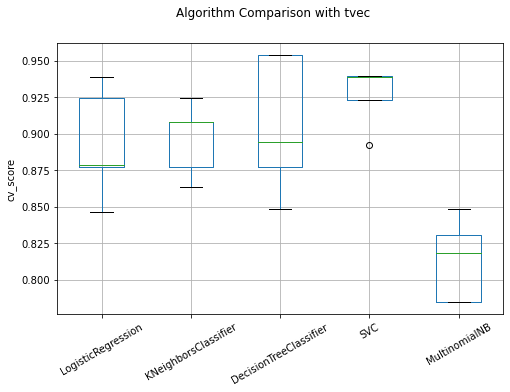

In [39]:
fig, ax = plt.subplots(figsize = (8,5))
fig.suptitle("Algorithm Comparison with tvec")
cv_score_df.boxplot()
plt.ylabel("cv_score")
ax.set_xticklabels(clean_labels)
plt.xticks(rotation=30)
plt.show()

The TfidfVectorizer - SVC() Model performed the best among the models trained with the TfidfVectorizer to extract text features. The training and test score were both slightly smaller than the CountVectorizer - Logistic Regression() model, so we will continue with the latter.

### Additional Improvements to word vectorizer

Elimination of stop words

In [40]:
# Instantiate classifiers to compare
models = [
    ('LR', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier()),
    ('SVC', SVC()),
    ('NB', MultinomialNB())
]

model_names = []
cv_std = {}
model_scores = {}

In [41]:
# create custom stopwords set
combined_stopwords = ENGLISH_STOP_WORDS.union(stopwords.words('french'))
custom_stopwords = ['data', 'scientist', 'science', 'scientist', 'skills', 'ability', 'bachelor', 'degree', 'work', 'years', 'equal', 'opportunity', 'employer', 'objectives', 'ontario', 'canada', 'disability', 'strong', 'including', 'understanding', 'related', 'experience', 'including', 'job', 'requirements']

#combine custom_stopwords and combined_stopwords from above
custcomb_stopwords = combined_stopwords.union(custom_stopwords)

cvec = CountVectorizer(analyzer = 'word', stop_words = custcomb_stopwords, lowercase= True, min_df=4)

In [43]:
print("Begin cross validating models:")
for name, model in models:
    train_baseline_model(model, x_train_tfidf, y_train, y_test, model_scores, name)
    print_summary(model, model_scores, cv_std)

Begin cross validating models:

Model:  LogisticRegression()
  - Average CV score: 0.9326340326340328
  - Standard deviation during CV: 0.03154286308716173

Model:  KNeighborsClassifier()
  - Average CV score: 0.785920745920746
  - Standard deviation during CV: 0.04000793222842295

Model:  DecisionTreeClassifier()
  - Average CV score: 0.9173892773892774
  - Standard deviation during CV: 0.02309532830115749

Model:  SVC()
  - Average CV score: 0.9235897435897436
  - Standard deviation during CV: 0.03349915557579514

Model:  MultinomialNB()
  - Average CV score: 0.9234498834498834
  - Standard deviation during CV: 0.0309585192648691


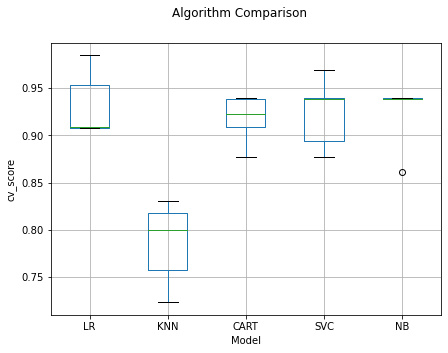

In [44]:
base_df = pd.DataFrame(model_scores)
base_df.columns = model_names

fig, ax = plt.subplots(figsize = (7,5))
fig.suptitle("Algorithm Comparison")
base_df.boxplot()
plt.ylabel("cv_score")
plt.xlabel("Model")
plt.show()

### Additional Improvements to Selected Baseline Model

In [67]:
# cvec = CountVectorizer(analyzer = 'word', stop_words = ENGLISH_STOP_WORDS, lowercase= True, min_df=4)
# vec = [cvec]
# model = [LogisticRegression(C=1)]
# c_vals = [0.01, 0.1, 1, 10, 100]
# params = {'model__C': c_vals}
# scoring = 'accuracy'
# test_lr = EvaluateModels(vec, model, params, scoring)

In [68]:
# test_lr.params

{'model__C': [0.01, 0.1, 1, 10, 100]}

In [69]:
# test_lr.run(x_train, y_train)

AttributeError: 'NoneType' object has no attribute 'set_params'

In [45]:
# LR C values
c_vals = [0.01, 0.1, 1, 10, 100]
params = {'model__C': c_vals}
model = LogisticRegression(C=1)

pipe = Pipeline([('vectorizer', cvec), ('model', model)])
grid = GridSearchCV(pipe, param_grid = params, cv=5, scoring='accuracy',return_train_score=True)
grid.fit(x_train.values, y_train.values)

print('Scores:')
print(f' -- Training set score: {str(grid.score(x_train.values, y_train.values))}')
print(f' -- Test set score: {str(grid.score(x_test.values, y_test.values))}')

Scores:
 -- Training set score: 1.0
 -- Test set score: 0.9574468085106383


In [46]:
best_score = grid.best_score_
print(f'The best mean cv score is {best_score}')

# Access the best set of parameters
best_params = grid.best_params_
print(best_params)

# Stores the optimum model in best_pipe
best_pipe = grid.best_estimator_
print(best_pipe)

The best mean cv score is 0.9234965034965035
{'model__C': 1}
Pipeline(steps=[('vectorizer',
                 CountVectorizer(min_df=4,
                                 stop_words=frozenset({'a', 'ability', 'about',
                                                       'above', 'across',
                                                       'after', 'afterwards',
                                                       'again', 'against', 'ai',
                                                       'aie', 'aient', 'aies',
                                                       'ait', 'all', 'almost',
                                                       'alone', 'along',
                                                       'already', 'also',
                                                       'although', 'always',
                                                       'am', 'among', 'amongst',
                                                       'amoungst', 'amount',
            

In [47]:
result_df = pd.DataFrame.from_dict(grid.cv_results_, orient='columns')

# take just cv scores and plot them

score_cols = [col for col in result_df.columns if 'split' in col]
test_score_df = result_df[score_cols].T
test_score_df.rename(columns= result_df['param_model__C'])

# get plot labels from tested param_
col_label = [col for col in result_df.columns if 'param_' in col]
col_label = str(col_label[0])
plot_label = result_df[col_label].values.tolist()
# plot_label

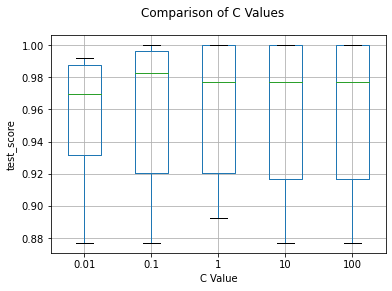

In [48]:
fig, ax = plt.subplots()
fig.suptitle("Comparison of C Values")
test_score_df.boxplot()
plt.ylabel("test_score")
ax.set_xticklabels(plot_label)
plt.xlabel("C Value")
plt.show()

Curiously, the best model remains to be the Count Vectorizer and Logistic Regression model with a C value of 1 (the default value).

### Additional Model Improvements

Ensemble methods

In [49]:
vecs = [cvec]
models = [RandomForestClassifier(),
            GradientBoostingClassifier(), 
            xgb.XGBClassifier()
            ]
params = {'model': models}
scoring = 'accuracy'
test_ensembles = EvaluateModels(vecs, models, params, scoring)

In [51]:
test_ensembles.run_cv(x_train, y_train)

TypeError: make_pipeline() missing 2 required positional arguments: 'vec' and 'model'

### Learning Curve

In [ ]:
def plot_learning_curve(estimator, X, y, cv=None, scoring=None, figsize=None):
    """Plot the learning curve"""

    train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(estimator, X, y, return_times=True)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # plot learning curve
    fig, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = 'r')
    ax.plot(train_sizes, test_scores_mean, "o-", color="g", label="Test Score")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color = 'g')
    
    ax.set_xlabel("Train size")
    ax.set_ylabel("scoring")

    plt.legend(loc="best")
    plt.title("Learning Curve")
    plt.show()

In [ ]:
# from custom_utils import plot_learning_curve
plot_learning_curve(model, x_train_tfidf, y_train, scoring="accuracy", figsize=(6,4))

In [ ]:
plot_learning_curve(model, x_test_tfidf, y_test, scoring='accuracy', figsize=(6,4))

The learning curve for the Random Forest Classifier indicates that the model is scoring very high with the training data with little error whiel the test data accuracy is improving with increasing data size but a gap remains between the two curves (indicates high variance). Increasing the data set size would help with this.

In [ ]:
# store feature importances if model has it
if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
    print("Model has feature importance attribute")
else:
    print("Model doesn't have feature importance attribute")

### Further Inspection of tree-based model

To better understand how our classifier is making predictions, we will look at the important features and permutation importance.

In [ ]:
features = tvec.get_feature_names_out()
indices = np.argsort(importances)
feat_importances = pd.Series(importances, index = features)

In [ ]:
feat_importances.nlargest(10).plot(kind='barh')
plt.gca().invert_yaxis()

In [ ]:
def save_features(model, feat_importances):
    with open("model_feat_importances.txt", 'w') as file:
        file.write(str(model))
    feat_importances.to_csv('feature_importance.csv')

save_features(model, feat_importances)

#### Permutation Importance

Permutation importance measures that importance of a feature by calculating the increase in the model's prediction error after permuting (or alter / rearrange) the feature. Therefore, a feature is considered important if the model relies on the feature for the prediction.


Reference:
Molnar, C. (2022). Interpretable Machine Learning:
A Guide for Making Black Box Models Explainable (2nd ed.).
christophm.github.io/interpretable-ml-book/

In [ ]:
from sklearn.inspection import permutation_importance

# permutation-based importance
perm_importance = permutation_importance(model, x_test_tfidf.toarray(), y_test)
sorted_idx = perm_importance.importances_mean.argsort()

In [ ]:
perm_df = pd.DataFrame(
    perm_importance.importances[sorted_idx].T,
    columns=features[sorted_idx]
)

In [ ]:
def save_permuation_importance(permuation_importance):
    perm_df.to_csv("permutation_importance.csv")

save_permuation_importance(perm_importance)

In [ ]:
fig = plt.figure(figsize = (5,8))
plt.boxplot(
    perm_importance.importances[sorted_idx][-10:].T,
    vert=False, 
    labels=features[sorted_idx][-10:]
)
fig.tight_layout()
plt.show()

The Random Forest Classifier and the Gradient Boosting Classifier have accuracy scores that are very similar. Consider tuning both to see which one can ultimately do better.